# Name - Vishwajeet Singh

# Project -: Barin Tumor Classification Using Machine Learning


### Step 1: Perform Data Analysis

In [1]:
# import libraries
from imutils import paths
import matplotlib.pyplot as plt
import argparse
import os
import cv2

# Load the images directories
path = "C:/Users/VISHWAJEET SINGH/ML Projects/brain_tumor_dataset"
image_paths = list(paths.list_images(path))

In [2]:
images = []
labels = []

for image_path in image_paths:
    label = image_path.split(os.path.sep)[-2]
    image = cv2.imread(image_path)
    image = cv2.resize(image, (224, 224))

    images.append(image)
    labels.append(label)

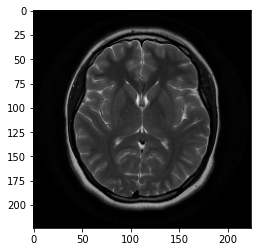

In [4]:
# Plot an image using the matplotlib module
def plot_image(image):
    plt.imshow(image)

plot_image(images[0])

In [5]:
# Normalize the images and convert our lists to numpy arrays to  further split our dataset
from sklearn.preprocessing import LabelBinarizer
from tensorflow.keras.utils import to_categorical
import numpy as np

images = np.array(images) / 255.0
labels = np.array(labels)

label_binarizer = LabelBinarizer()
labels = label_binarizer.fit_transform(labels)
labels = to_categorical(labels)

In [6]:
# Split the dataset into training and testing sets
from sklearn.model_selection import train_test_split

(train_X, test_X, train_Y, test_Y) = train_test_split(images, labels, test_size= 0.10, random_state= 42, stratify= labels)

### Step 2: Build a CNN Model

In [7]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
train_generator = ImageDataGenerator(fill_mode= 'nearest', rotation_range= 15)

In [8]:
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.applications import VGG16

base_model = VGG16(weights= 'imagenet', input_tensor= Input(shape = (224, 224, 3)), include_top= False)
base_input = base_model.input

base_output = base_model.output
base_output = AveragePooling2D(pool_size=(4, 4))(base_output)
base_output = Flatten(name="flatten")(base_output)
base_output = Dense(64, activation="relu")(base_output)
base_output = Dropout(0.5)(base_output)
base_output = Dense(2, activation="softmax")(base_output)

In [9]:
for layer in base_model.layers:
    layer.trainable = False

In [10]:
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

model = Model(inputs = base_input, outputs = base_output)
model.compile(optimizer= Adam(learning_rate= 1e-3), metrics= ['accuracy'], loss= 'binary_crossentropy')

In [11]:
# See the architecture summary of our model
model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)      

### Step 3: Train and evaluate the model

In [12]:
batch_size = 8
train_steps = len(train_X) // batch_size
validation_steps = len(test_X) // batch_size
epochs = 10

In [13]:
# Let's train our model
history = model.fit_generator(train_generator.flow(train_X, train_Y, batch_size= batch_size), steps_per_epoch= train_steps, validation_data = (test_X, test_Y), validation_steps= validation_steps, epochs= epochs)

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/10
28/28 [==============================] - 81s 3s/step - loss: 0.7093 - accuracy: 0.5890 - val_loss: 0.6024 - val_accuracy: 0.6154
Epoch 2/10
28/28 [==============================] - 75s 3s/step - loss: 0.6451 - accuracy: 0.6484 - val_loss: 0.5550 - val_accuracy: 0.7692
Epoch 3/10
28/28 [==============================] - 98s 3s/step - loss: 0.6035 - accuracy: 0.6895 - val_loss: 0.5033 - val_accuracy: 0.9231
Epoch 4/10
28/28 [==============================] - 103s 4s/step - loss: 0.5971 - accuracy: 0.6804 - val_loss: 0.4699 - val_accuracy: 0.9231
Epoch 5/10
28/28 [==============================] - 77s 3s/step - loss: 0.5836 - accuracy: 0.6530 - val_loss: 0.4305 - val_accuracy: 0.9615
Epoch 6/10
28/28 [==============================] - 95s 3s/step - loss: 0.5534 - accuracy: 0.7215 - val_loss: 0.4010 - val_accuracy: 0.9615
Epoch 7/10
28/28 [==============================] - 90s 3s/step - loss: 0.5417 - ac

Our model got 96.15% accuracy on the test set. Now let’s evaluate our model using the predict() function.

In [14]:
from sklearn.metrics import classification_report, confusion_matrix

# Evaluate the model
predictions = model.predict(test_X, batch_size= batch_size)
predictions = np.argmax(predictions, axis= 1)
actuals = np.argmax(test_Y, axis= 1)

#Print Classification report and confusion matrix
print(classification_report(actuals, predictions, target_names= label_binarizer.classes_))

cm = confusion_matrix(actuals, predictions)
print(cm)

              precision    recall  f1-score   support

          no       0.91      1.00      0.95        10
         yes       1.00      0.94      0.97        16

    accuracy                           0.96        26
   macro avg       0.95      0.97      0.96        26
weighted avg       0.97      0.96      0.96        26

[[10  0]
 [ 1 15]]


In [15]:
#Find the overall accuracy of the model
total = sum(sum(cm))
accuracy = (cm[0, 0] + cm[1, 1]) / total
print("Accuracy: {:.4f}".format(accuracy))

Accuracy: 0.9615


The accuracy of our model is found to be 96.15%

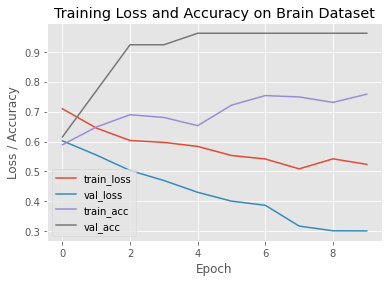

In [16]:
# Now plots the Losses and accuracies
N = epochs
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), history.history["loss"], label= "train_loss")
plt.plot(np.arange(0, N), history.history["val_loss"], label= "val_loss")

plt.plot(np.arange(0, N), history.history["accuracy"], label= "train_acc")
plt.plot(np.arange(0, N), history.history["val_accuracy"], label= "val_acc")

plt.title("Training Loss and Accuracy on Brain Dataset")
plt.xlabel("Epoch")
plt.ylabel("Loss / Accuracy")
plt.legend(loc= "lower left")
plt.savefig("plot.jpg")

#### Summary

In this brain tumor classification using machine learning project, we built a binary classifier to detect brain tumors from MRI scan images. We built our classifier using transfer learning and obtained an accuracy of 96.15% and visualized our model’s overall performance.